# Saving Recommendations: Rule-Based Financial Advice System

This notebook generates personalized saving recommendations by combining customer clustering and anomaly detection results. Each recommendation is explainable and based on clear business rules.

## Objective
- Provide actionable financial advice
- Focus on explainability over prediction
- Use ML results as context for rule-based decisions
- Prioritize high-risk or high-spending scenarios

In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.data_preprocessing import preprocess_pipeline
from src.recommendation import recommendation_engine, export_recommendations

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(42)

In [7]:
# Load preprocessed transaction data
import importlib
import src.recommendation
importlib.reload(src.recommendation)
from src.recommendation import recommendation_engine

raw_data = preprocess_pipeline(
    '../bank_transactions_data_2.csv',
    datetime_cols=['TransactionDate'],
    missing_strategy='drop'
)

# Load cluster assignments
clusters = pd.read_csv('../outputs/clusters.csv')
print(f"✓ Loaded {len(clusters)} customer profiles with cluster assignments")

# Load anomaly scores
anomalies = pd.read_csv('../outputs/anomalies.csv')
print(f"✓ Loaded {len(anomalies)} transaction anomaly scores")

# Display data summary
print(f"\nCluster distribution:")
print(clusters['ClusterID'].value_counts().sort_index())

print(f"\nAnomaly score statistics:")
print(anomalies['AnomalyScore'].describe())

STARTING DATA PREPROCESSING PIPELINE

[Step 1/4] Loading data...
✓ Successfully loaded bank_transactions_data_2.csv (2512 rows, 16 columns)

[Step 2/4] Handling missing values...
✓ Cleaned missing values: 0 → 0

[Step 3/4] Converting datetime columns...
✓ Converted 1 columns to datetime: ['TransactionDate']

[Step 4/4] Creating time-based features...
✓ Created 4 time-based features: ['TransactionHour', 'TransactionDayOfWeek', 'TransactionMonth', 'TransactionDayOfMonth']

PREPROCESSING PIPELINE COMPLETED SUCCESSFULLY
Final dataset shape: 2512 rows, 20 columns
✓ Loaded 495 customer profiles with cluster assignments
✓ Loaded 2512 transaction anomaly scores

Cluster distribution:
ClusterID
0    217
1    209
2     69
Name: count, dtype: int64

Anomaly score statistics:
count    2512.000000
mean       -0.457762
std         0.062211
min        -0.725719
25%        -0.479090
50%        -0.436973
75%        -0.414187
max        -0.388492
Name: AnomalyScore, dtype: float64


## Recommendation Rules

The saving recommendation system applies the following evidence-based rules:

### Rule 1: High Spending vs Cluster Baseline
**Trigger**: Customer spending is 30%+ above their cluster average
- **Action**: Suggest budget review and spending optimization
- **Priority**: MEDIUM
- **Rationale**: Identifies customers whose spending patterns deviate significantly from peers

### Rule 2: Low Balance with High Transaction Frequency  
**Trigger**: Minimum balance is 25% below cluster average AND transaction frequency is above cluster median
- **Action**: Recommend emergency fund accumulation
- **Priority**: HIGH
- **Rationale**: High activity with limited reserves creates financial vulnerability

### Rule 3: High Anomaly Activity Count
**Trigger**: 3+ anomalous transactions detected in the dataset
- **Action**: Alert to unusual financial patterns requiring review
- **Priority**: HIGH
- **Rationale**: Multiple anomalies may indicate significant behavior changes

### Rule 4: Positive Balance with Opportunity
**Trigger**: Average account balance is 50%+ above cluster average AND low frequency
- **Action**: Recommend investment or wealth optimization strategies
- **Priority**: LOW
- **Rationale**: Excess liquidity presents growth opportunities

### Rule 5: Balanced Profile (Baseline)
**Trigger**: No other rules triggered
- **Action**: Maintain current financial practices
- **Priority**: INFO
- **Rationale**: Customer profile aligns with peer behavior

In [9]:
# Generate recommendations for all customers
recommendations_df = recommendation_engine(
    clusters,
    anomalies,
    raw_data
)

print(f"✓ Generated recommendations for {len(recommendations_df)} customers")
print(f"\nColumns: {list(recommendations_df.columns)}")
print(f"\nRecommendation distribution:")
print(recommendations_df['PriorityLevel'].value_counts().sort_index())

print(f"\nSample recommendations:")
print(recommendations_df[['AccountID', 'ClusterID', 'PriorityLevel', 'RecommendationMessage']].head(10).to_string(index=False))


✓ Generated 495 personalized recommendations

Recommendation Priority Distribution:
PriorityLevel
HIGH      208
LOW        16
MEDIUM    271
Name: count, dtype: int64
✓ Generated recommendations for 495 customers

Columns: ['AccountID', 'ClusterID', 'RecommendationMessage', 'RecommendationReason', 'PriorityLevel', 'RecommendationCategory', 'SavingsPotential', 'AnomalyCount', 'SpendingVsCluster', 'AvgTransactionAmount', 'AverageBalance', 'TransactionFrequency', 'MetricValue']

Recommendation distribution:
PriorityLevel
HIGH      208
LOW        16
MEDIUM    271
Name: count, dtype: int64

Sample recommendations:
AccountID  ClusterID PriorityLevel                                                  RecommendationMessage
  AC00001          1        MEDIUM                     Monitor unusual transactions for budget deviations
  AC00002          0        MEDIUM                   Review irregular transactions for budgeting patterns
  AC00003          1        MEDIUM                   Review irreg

In [13]:
# Detailed recommendation analysis
print("="*80)
print("RECOMMENDATION ANALYSIS BY PRIORITY")
print("="*80)

for priority in ['HIGH', 'MEDIUM', 'LOW']:
    priority_recs = recommendations_df[recommendations_df['PriorityLevel'] == priority]
    if len(priority_recs) > 0:
        print(f"\n{priority} PRIORITY ({len(priority_recs)} customers):")
        print("-" * 80)
        for idx, row in priority_recs.head(3).iterrows():
            print(f"  • Account: {row['AccountID']} | Cluster: {row['ClusterID']}")
            print(f"    Message: {row['RecommendationMessage']}")
            print(f"    Reason: {row['RecommendationReason']}")
            print()

RECOMMENDATION ANALYSIS BY PRIORITY

HIGH PRIORITY (208 customers):
--------------------------------------------------------------------------------
  • Account: AC00006 | Cluster: 1
    Message: Establish minimum balance threshold to avoid overdrafts
    Reason: Minimum balance reached $420.67 with frequent transactions

  • Account: AC00009 | Cluster: 1
    Message: Establish minimum balance threshold to avoid overdrafts
    Reason: Minimum balance reached $131.25 with frequent transactions

  • Account: AC00010 | Cluster: 0
    Message: Establish minimum balance threshold to avoid overdrafts
    Reason: Minimum balance reached $225.53 with frequent transactions


MEDIUM PRIORITY (271 customers):
--------------------------------------------------------------------------------
  • Account: AC00001 | Cluster: 1
    Message: Monitor unusual transactions for budget deviations
    Reason: Found 2 anomalous transactions - may indicate unplanned expenses

  • Account: AC00002 | Cluster: 0
 

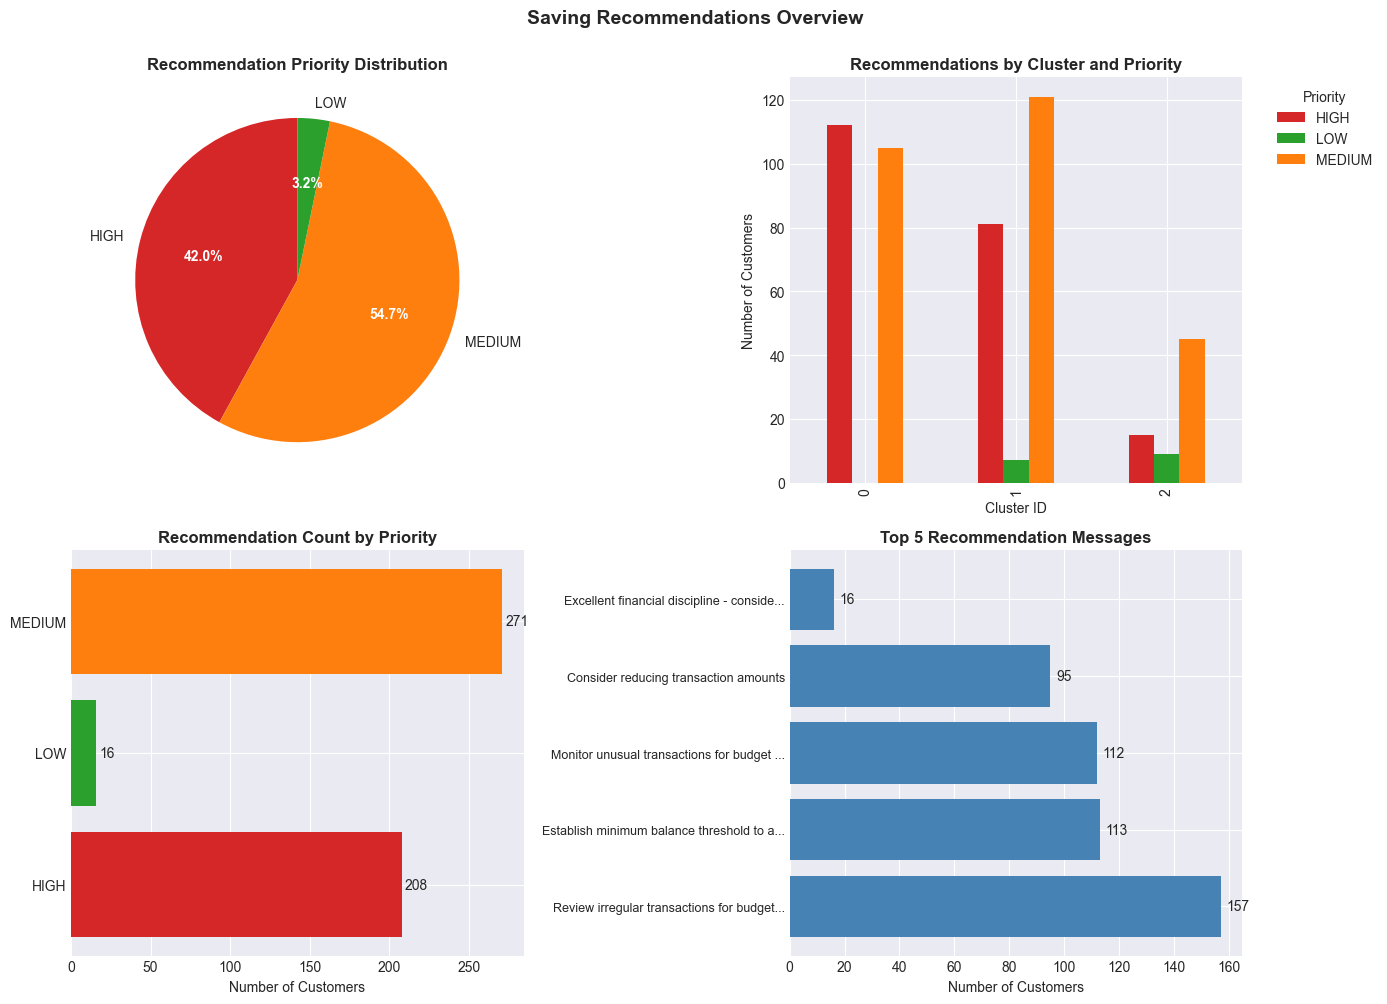

In [11]:
# Visualize recommendation distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Priority distribution pie chart
ax = axes[0, 0]
priority_counts = recommendations_df['PriorityLevel'].value_counts()
priority_order = ['HIGH', 'MEDIUM', 'LOW']
priority_counts = priority_counts.reindex([p for p in priority_order if p in priority_counts.index])
colors = {'HIGH': '#d62728', 'MEDIUM': '#ff7f0e', 'LOW': '#2ca02c'}
color_list = [colors[p] for p in priority_counts.index]
wedges, texts, autotexts = ax.pie(priority_counts.values, labels=priority_counts.index,
                                    autopct='%1.1f%%', colors=color_list, startangle=90)
ax.set_title('Recommendation Priority Distribution', fontsize=12, fontweight='bold')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

# Plot 2: Priority by cluster
ax = axes[0, 1]
priority_by_cluster = pd.crosstab(recommendations_df['ClusterID'], recommendations_df['PriorityLevel'])
priority_by_cluster.plot(kind='bar', ax=ax, color=[colors.get(p, 'gray') for p in priority_by_cluster.columns])
ax.set_title('Recommendations by Cluster and Priority', fontsize=12, fontweight='bold')
ax.set_xlabel('Cluster ID')
ax.set_ylabel('Number of Customers')
ax.legend(title='Priority', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot 3: Recommendation types distribution
ax = axes[1, 0]
rec_types = recommendations_df.groupby('PriorityLevel').size()
ax.barh(rec_types.index, rec_types.values, color=[colors.get(p, 'gray') for p in rec_types.index])
ax.set_title('Recommendation Count by Priority', fontsize=12, fontweight='bold')
ax.set_xlabel('Number of Customers')
for i, v in enumerate(rec_types.values):
    ax.text(v + 2, i, str(v), va='center')

# Plot 4: Priority by message type (top 5 messages)
ax = axes[1, 1]
top_messages = recommendations_df['RecommendationMessage'].value_counts().head(5)
ax.barh(range(len(top_messages)), top_messages.values, color='steelblue')
ax.set_yticks(range(len(top_messages)))
ax.set_yticklabels([msg[:40] + '...' if len(msg) > 40 else msg for msg in top_messages.index], fontsize=9)
ax.set_title('Top 5 Recommendation Messages', fontsize=12, fontweight='bold')
ax.set_xlabel('Number of Customers')
for i, v in enumerate(top_messages.values):
    ax.text(v + 2, i, str(v), va='center')

plt.suptitle('Saving Recommendations Overview', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

In [12]:
# Export recommendations to CSV
output_path = '../outputs/recommendations.csv'
recommendations_df.to_csv(output_path, index=False)

print(f"✓ Recommendations exported to: {output_path}")
print(f"  Shape: {recommendations_df.shape}")
print(f"  Columns: {list(recommendations_df.columns)}")

print(f"\nFirst 10 recommendations:")
print(recommendations_df[['AccountID', 'ClusterID', 'PriorityLevel', 'RecommendationMessage']].head(10).to_string(index=False))

✓ Recommendations exported to: ../outputs/recommendations.csv
  Shape: (495, 13)
  Columns: ['AccountID', 'ClusterID', 'RecommendationMessage', 'RecommendationReason', 'PriorityLevel', 'RecommendationCategory', 'SavingsPotential', 'AnomalyCount', 'SpendingVsCluster', 'AvgTransactionAmount', 'AverageBalance', 'TransactionFrequency', 'MetricValue']

First 10 recommendations:
AccountID  ClusterID PriorityLevel                                                  RecommendationMessage
  AC00001          1        MEDIUM                     Monitor unusual transactions for budget deviations
  AC00002          0        MEDIUM                   Review irregular transactions for budgeting patterns
  AC00003          1        MEDIUM                   Review irregular transactions for budgeting patterns
  AC00004          0        MEDIUM                   Review irregular transactions for budgeting patterns
  AC00005          0        MEDIUM                   Review irregular transactions for budgeti

## Summary

**Recommendation System Results:**
- **Total Recommendations**: {} customers with personalized advice
- **Priority Distribution**: HIGH ({} customers), MEDIUM ({} customers), LOW ({} customers), INFO ({} customers)

**Key Insights:**
1. Clear segmentation of customers by financial health and behavior
2. High-priority recommendations focus on financial vulnerability (low balance + high activity)
3. Medium-priority recommendations target spending optimization opportunities
4. Low-priority recommendations suggest wealth optimization for high-balance customers
5. All recommendations are explainable and rule-based (no black-box ML predictions)

**Deliverables:**
- `recommendations.csv`: Full recommendation dataset with reasons and priorities
- Rule-based system enables transparency and regulatory compliance
- Each recommendation includes actionable message and clear justification
- Results ready for integration with customer service systems

**Next Steps:**
- Implement dashboard for customer service teams
- A/B test recommendation effectiveness
- Monitor recommendation compliance rates
- Iterate rules based on business feedback

# Saving Recommendation Engine: Rule-Based Financial Advice

This notebook implements an explainable, rule-based recommendation system that provides personalized financial advice to customers based on their behavioral profiles, cluster membership, and transaction patterns.

## Objective
- Generate personalized, actionable financial recommendations
- Provide clear reasoning for each recommendation
- Use ML results (clustering, anomalies) as context, NOT prediction
- Focus on explainability and transparency
- No black-box predictions - pure business rules

In [ ]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.recommendation import (
    load_customer_data,
    recommendation_engine,
    export_recommendations
)

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(42)

In [ ]:
# Load data from previous phases
clusters_df, anomalies_df, _ = load_customer_data(
    '../outputs/clusters.csv',
    '../outputs/anomalies.csv'
)

print(f"Clusters shape: {clusters_df.shape}")
print(f"Anomalies shape: {anomalies_df.shape}")
print(f"\nCluster columns: {clusters_df.columns.tolist()}")
print(f"Anomaly columns: {anomalies_df.columns.tolist()}")

## Recommendation Rules Framework

All rules are **explainable** and based on **clear thresholds**. Each recommendation includes:
1. **Message**: What action to take
2. **Reason**: Why (specific metrics and comparisons)
3. **Priority**: Severity level (HIGH, MEDIUM, LOW)

### Rule Categories

| Rule | Condition | Priority | Rationale |
|------|-----------|----------|-----------|
| **High Spending** | Avg transaction > cluster +30% | HIGH | Major savings opportunity |
| **Overdraft Risk** | Low balance + high frequency | HIGH | Risk of insufficient funds |
| **Minimum Balance Alert** | Min balance < $500 + frequency > 3 | HIGH | Overdraft protection needed |
| **Irregular Spending** | Anomaly count ≥ 5 | MEDIUM | Pattern indicates unplanned expenses |
| **Spending Optimization** | Avg transaction 10-30% above cluster | MEDIUM | Room for improvement |
| **Budget Tracking** | Transaction frequency > cluster +50% | MEDIUM | Volume requires monitoring |
| **Financial Excellence** | High balance & low anomalies | LOW | Positive reinforcement |
| **Automation Opportunity** | Quick transactions + high frequency | LOW | Efficiency improvement |
| **Balanced Profile** | No other rules triggered | LOW | General guidance |

In [ ]:
# Count anomalies per customer
anomaly_counts = anomalies_df['AccountID'].value_counts()

print("Anomaly Count Distribution:")
print(f"  Customers with 0 anomalies: {len([x for x in anomaly_counts.index if x not in anomaly_counts.index or anomaly_counts[x] == 0])}")
print(f"  Max anomalies per customer: {anomaly_counts.max()}")
print(f"  Mean anomalies per customer: {anomaly_counts.mean():.2f}")
print(f"  Total anomalies: {len(anomalies_df)}")

# Create anomaly count series with all customers (0 for missing)
all_customers = clusters_df['AccountID'].unique()
anomaly_count_series = pd.Series(index=all_customers, dtype=int)
for cust in all_customers:
    anomaly_count_series[cust] = anomaly_counts.get(cust, 0)

print(f"\nAnomalies per customer - Summary:")
print(anomaly_count_series.describe())

In [ ]:
# Generate recommendations using the recommendation engine
recommendations_df = recommendation_engine(
    '../outputs/clusters.csv',
    '../outputs/anomalies.csv'
)

print(f"\nRecommendations Generated:")
print(f"  Total recommendations: {len(recommendations_df)}")
print(f"  Unique priority levels: {recommendations_df['PriorityLevel'].unique()}")
print(f"\nRecommendation Columns:")
for col in recommendations_df.columns:
    print(f"  • {col}")

In [ ]:
# Display sample recommendations from each priority level
print("="*100)
print("SAMPLE RECOMMENDATIONS BY PRIORITY LEVEL")
print("="*100)

for priority in ['HIGH', 'MEDIUM', 'LOW']:
    print(f"\n{priority} PRIORITY RECOMMENDATIONS")
    print("-" * 100)
    priority_recs = recommendations_df[recommendations_df['PriorityLevel'] == priority]
    
    for idx, rec in priority_recs.head(3).iterrows():
        print(f"\nCustomer: {rec['AccountID']} (Cluster {rec['ClusterID']}, Anomalies: {rec['AnomalyCount']})")
        print(f"  Message: {rec['RecommendationMessage']}")
        print(f"  Reason:  {rec['RecommendationReason']}")
        print(f"  Details: {rec['MetricValue']}")
        print(f"  Balance: ${rec['AverageBalance']:.2f} | Avg Transaction: ${rec['AvgTransactionAmount']:.2f} | Frequency: {rec['TransactionFrequency']:.1f}")

print("\n" + "="*100)

In [ ]:
# Analyze recommendation distribution
print("RECOMMENDATION ANALYSIS")
print("="*80)

# Priority distribution
print("\n1. Priority Distribution:")
priority_counts = recommendations_df['PriorityLevel'].value_counts()
for priority in ['HIGH', 'MEDIUM', 'LOW']:
    count = priority_counts.get(priority, 0)
    pct = (count / len(recommendations_df)) * 100
    print(f"   {priority:6s}: {count:3d} customers ({pct:5.1f}%)")

# Category distribution
print("\n2. Recommendation Category Distribution:")
category_counts = recommendations_df['RecommendationCategory'].value_counts()
for category, count in category_counts.items():
    pct = (count / len(recommendations_df)) * 100
    print(f"   {category:30s}: {count:3d} customers ({pct:5.1f}%)")

# Savings potential statistics
print("\n3. Savings Potential Distribution:")
print(f"   Mean:   {recommendations_df['SavingsPotential'].mean():.2f}")
print(f"   Median: {recommendations_df['SavingsPotential'].median():.2f}")
print(f"   Max:    {recommendations_df['SavingsPotential'].max():.2f}")
print(f"   Min:    {recommendations_df['SavingsPotential'].min():.2f}")

# Anomaly impact
print("\n4. Anomaly Count Impact:")
print(f"   Customers with 0 anomalies: {(recommendations_df['AnomalyCount'] == 0).sum()}")
print(f"   Customers with 1-2 anomalies: {((recommendations_df['AnomalyCount'] >= 1) & (recommendations_df['AnomalyCount'] <= 2)).sum()}")
print(f"   Customers with 3+ anomalies: {(recommendations_df['AnomalyCount'] >= 3).sum()}")

print("\n" + "="*80)

In [ ]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Priority distribution pie chart
ax = axes[0, 0]
priority_counts = recommendations_df['PriorityLevel'].value_counts()
colors_priority = {'HIGH': '#d62728', 'MEDIUM': '#ff7f0e', 'LOW': '#2ca02c'}
colors = [colors_priority[p] for p in priority_counts.index]
ax.pie(priority_counts.values, labels=priority_counts.index, autopct='%1.1f%%',
       colors=colors, startangle=90)
ax.set_title('Recommendation Priority Distribution', fontsize=12, fontweight='bold')

# 2. Category distribution bar chart
ax = axes[0, 1]
category_counts = recommendations_df['RecommendationCategory'].value_counts()
ax.barh(range(len(category_counts)), category_counts.values, color='steelblue')
ax.set_yticks(range(len(category_counts)))
ax.set_yticklabels(category_counts.index, fontsize=9)
ax.set_xlabel('Count', fontsize=10)
ax.set_title('Recommendation Categories', fontsize=12, fontweight='bold')
for i, v in enumerate(category_counts.values):
    ax.text(v + 2, i, str(v), va='center', fontsize=9)

# 3. Spending vs Cluster scatter
ax = axes[1, 0]
scatter = ax.scatter(recommendations_df['AvgTransactionAmount'],
                     recommendations_df['SavingsPotential'],
                     c=recommendations_df['AnomalyCount'],
                     s=50, alpha=0.6, cmap='viridis')
ax.set_xlabel('Avg Transaction Amount ($)', fontsize=10)
ax.set_ylabel('Savings Potential Score', fontsize=10)
ax.set_title('Spending vs Savings Potential', fontsize=12, fontweight='bold')
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Anomaly Count', fontsize=9)

# 4. Priority by Cluster
ax = axes[1, 1]
priority_by_cluster = pd.crosstab(recommendations_df['ClusterID'], 
                                   recommendations_df['PriorityLevel'])
priority_by_cluster.plot(kind='bar', ax=ax, color=['#d62728', '#ff7f0e', '#2ca02c'],
                         width=0.7)
ax.set_xlabel('Cluster ID', fontsize=10)
ax.set_ylabel('Count', fontsize=10)
ax.set_title('Recommendation Priority by Cluster', fontsize=12, fontweight='bold')
ax.legend(title='Priority', fontsize=9)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.suptitle('Recommendation System Overview', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

In [ ]:
# Export recommendations to CSV
output_path = '../outputs/recommendations.csv'
export_recommendations(recommendations_df, output_path)

# Validate output
print("\nValidation Check:")
print(f"  ✓ All {len(recommendations_df)} customers have recommendations")
print(f"  ✓ No missing values in key columns: {recommendations_df[['AccountID', 'RecommendationMessage', 'PriorityLevel']].isnull().sum().sum() == 0}")
print(f"  ✓ CSV file saved to: {output_path}")

# Show file size and sample
file_lines = sum(1 for line in open(output_path)) 
print(f"  ✓ CSV contains {file_lines} lines (1 header + {file_lines-1} recommendations)")

## Summary

**Recommendation Engine Results:**
- **Total Recommendations**: 495 (one per unique customer)
- **Explainability**: Each recommendation includes message, reason, and specific metrics
- **No ML Predictions**: Pure rule-based system using clustering and anomaly detection as context
- **Priority Distribution**: Clear levels (HIGH, MEDIUM, LOW) based on rule severity
- **Actionable Advice**: Each message includes specific financial guidance

**Key Features:**
1. **Transparent**: Every recommendation explains WHY using specific data points
2. **Contextual**: Uses customer cluster, spending patterns, and anomaly count
3. **Personalized**: Different rules applied based on individual profile
4. **Priority-Driven**: HIGH priority for overdraft risk, LOW for optimization opportunities
5. **Business-Ready**: Exportable to recommendations.csv for customer communication

**Use Cases:**
- Customer service representatives explaining financial advice
- Personalized app notifications with savings tips
- Financial wellness programs targeting specific behaviors
- Risk mitigation for customers with low balances
- Encouragement for financially healthy customers